# Задание 3

Подключаем необходимые библиотеки

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

### Задание 1
Сформировать обучающую выборку из загруженного датасета, состоящую из столбцов: ['Count_subj', 'rr_interval', 'p_end',  'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status’]. Датасет состоит из числовых параметров ЭКГ и классификационного признака Healthy_Status.

In [7]:
dataset = pd.read_csv('dataset.csv')
dataset.head(10)

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,19557662,27,40000017,6848296,0,8:44 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79
1,18477137,93,40000029,6848296,0,9:54 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70
2,16598616,3,40000035,6376932,1,9:07 AM,28.06.2015,Sinus tachycardia,NaN,Normal ECG except for rate,...,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77
3,16368287,7,40000079,6214760,1,5:14 PM,15.07.2015,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,659,40,146,180,254,538,79,66,69
4,18370366,2,40000084,6632385,0,1:52 PM,27.09.2015,Sinus rhythm,NaN,NaN,...,<not specified>,659,368,29999,504,590,868,84,80,77
5,15606157,55,40000089,6632385,0,2:29 PM,29.10.2013,Sinus rhythm,NaN,NaN,...,<not specified>,822,365,29999,499,592,852,26,46,30
6,12576058,43,40000115,6852956,1,12:54 PM,23.03.2016,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,952,40,146,198,282,598,24,80,20
7,14691089,1,40000143,6551957,0,10:01 AM,10.12.2016,Sinus rhythm,rSr'(V1) - probable normal variant,Low QRS voltages in precordial leads,...,60 Hz notch Baseline filter,923,40,140,188,278,594,26,86,13
8,14144725,7,40000144,6924910,0,7:24 AM,11.12.2011,Sinus rhythm with PAC(s).,NaN,Borderline ECG,...,60 Hz notch Baseline filter,952,40,180,196,294,610,59,-17,3
9,16089780,2,40000152,6919786,0,12:35 PM,13.12.2011,Sinus rhythm,Extensive T wave changes may be due to myocard...,NaN,...,60 Hz notch Baseline filter,1000,40,156,178,274,584,8,-11,19


In [9]:
# Предобрабатываем данные словестных репортов word2vec в числовой вектор

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = dataset[(dataset[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)

# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()

,subject_id,Count_subj,study_id,cart_id,eeg_time,eeg_date,report,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,19557662,27,40000017,6848296,8:44 AM,27.06.2015,0.038067,659,40,128,170,258,518,81,77,79,0
1,18477137,93,40000029,6848296,9:54 AM,27.06.2015,0.038067,722,40,124,162,246,504,77,75,70,0
2,16598616,3,40000035,6376932,9:07 AM,28.06.2015,-0.007039,600,40,130,162,244,474,79,72,77,1
3,16368287,7,40000079,6214760,5:14 PM,15.07.2015,0.000482,659,40,146,180,254,538,79,66,69,1
6,12576058,43,40000115,6852956,12:54 PM,23.03.2016,0.000482,952,40,146,198,282,598,24,80,20,1


In [10]:
# make new dataset from old columns
table_data = full_df_filtered[['Count_subj', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()
table_data.head()

,Count_subj,rr_interval,p_end,qrs_onset,qrs_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,27,659,128,170,258,81,77,79,0
1,93,722,124,162,246,77,75,70,0
2,3,600,130,162,244,79,72,77,1
3,7,659,146,180,254,79,66,69,1
6,43,952,146,198,282,24,80,20,1


### Задание 2
Используя выбранные ранее решения AutoML, найдите наиболее эффективное, используя такие метрика качества как: матрица ошибок (confusion matrix) и F1-метрика для оценки обученного классификатора по признаку Healthy_Status на основе данных параметров ЭКГ.

In [14]:
train_data, test_data = train_test_split(table_data, test_size=0.2, stratify=table_data['Healthy_Status'], random_state=42)

In [16]:
train_data, validation_data = train_test_split(
    train_data, 
    test_size=0.2, 
    stratify=train_data['Healthy_Status'], 
    random_state=42
)

## AutoML LAMA

In [19]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [20]:
automl = TabularAutoML(
    task=Task('binary'),
    timeout=100,
    cpu_limit=4,
    reader_params={'n_jobs': 4, 'cv': 3, 'random_state': 42},
)

In [21]:
predictions = automl.fit_predict(train_data, roles={'target': 'Healthy_Status'}, verbose=0).data

In [22]:
validation_predictions = automl.predict(validation_data).data

In [23]:
for i in range(len(validation_predictions)):
    if validation_predictions[i] > 0.5:
        validation_predictions[i] = 1
    else:
        validation_predictions[i] = 0

In [26]:
f1_lama_validation = f1_score(validation_data['Healthy_Status'], validation_predictions)

In [27]:
cm_lama_validation = confusion_matrix(validation_data['Healthy_Status'], validation_predictions, labels=[0, 1])

## AutoML H2O

In [29]:
import h2o
from h2o.automl import H2OAutoML

# Инициализация H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 21.0.5+-13047016-b750.29, mixed mode)
  Starting server from C:\Users\dvm10\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\dvm10\AppData\Local\Temp\tmp3ud293h9
  JVM stdout: C:\Users\dvm10\AppData\Local\Temp\tmp3ud293h9\h2o_dvm10_started_from_python.out
  JVM stderr: C:\Users\dvm10\AppData\Local\Temp\tmp3ud293h9\h2o_dvm10_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,5 months and 16 days
H2O_cluster_name:,H2O_from_python_dvm10_15sw1b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.932 Gb
H2O_cluster_total_cores:,20
H2O_cluster_allowed_cores:,20
H2O_cluster_status:,"locked, healthy"


In [30]:
# Подготовка данных в вашем формате
X_train = train_data.iloc[:, train_data.columns != 'Healthy_Status'].values
y_train = train_data.iloc[:, train_data.columns == 'Healthy_Status'].values.reshape(-1)

X_validation = validation_data.iloc[:, validation_data.columns != 'Healthy_Status'].values
y_validation = validation_data.iloc[:, validation_data.columns == 'Healthy_Status'].values.reshape(-1)

X_test = test_data.iloc[:, test_data.columns != 'Healthy_Status'].values
y_test = test_data.iloc[:, test_data.columns == 'Healthy_Status'].values.reshape(-1)

In [31]:
# Преобразование в H2OFrame (объединяем X и y)
def to_h2o_frame(X, y, col_names):
    """Создает H2OFrame из numpy массивов"""
    df = np.column_stack((X, y))
    hf = h2o.H2OFrame(df, column_names=col_names + ['Healthy_Status'])
    hf['Healthy_Status'] = hf['Healthy_Status'].asfactor()
    return hf

In [32]:
# Получаем имена признаков
feature_names = [col for col in train_data.columns if col != 'Healthy_Status']

In [33]:
# Создаем H2O фреймы
train_hf = to_h2o_frame(X_train, y_train, feature_names)
validation_hf = to_h2o_frame(X_validation, y_validation, feature_names)
test_hf = to_h2o_frame(X_test, y_test, feature_names)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [34]:
# Определение признаков и целевой переменной
x = feature_names
y = 'Healthy_Status'

In [35]:
# Создание и обучение модели H2OAutoML
aml = H2OAutoML(
    max_runtime_secs=300,  # 5 минут = 300 секунд
    seed=42,
    exclude_algos=["DeepLearning"],
    verbosity='info'
)
aml.train(x=x, y=y, training_frame=train_hf)

AutoML progress: |
23:36:23.847: Project: AutoML_1_20250418_233623
23:36:23.848: 5-fold cross-validation will be used.
23:36:23.850: Setting stopping tolerance adaptively based on the training frame: 0.014893886718362483
23:36:23.850: Build control seed: 42
23:36:23.850: training frame: Frame key: AutoML_1_20250418_233623_training_py_1_sid_b0fa    cols: 9    rows: 4508  chunks: 1    size: 69350  checksum: -46029330590490
23:36:23.850: validation frame: NULL
23:36:23.850: leaderboard frame: NULL
23:36:23.850: blending frame: NULL
23:36:23.851: response column: Healthy_Status
23:36:23.851: fold column: null
23:36:23.851: weights column: null
23:36:23.856: AutoML: XGBoost is not available; skipping it.
23:36:23.858: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), de

key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/4
# GBM base models (used / total),1/1
# DRF base models (used / total),2/2
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
Custom metalearner hyperparameters,None


In [36]:
# Получение лучшей модели
best_model = aml.leader

In [37]:
# Предсказания на валидационном наборе
preds_val = best_model.predict(validation_hf)
y_validation_h2o_predict = preds_val['predict'].as_data_frame().values.ravel()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\dvm10\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [38]:
# Метрики
f1_h2o_validation = f1_score(y_validation, y_validation_h2o_predict)
cm_h2o_validation = confusion_matrix(y_validation, y_validation_h2o_predict, labels=[0, 1])

In [39]:
# Для тестового набора (аналогично)
preds_test = best_model.predict(test_hf)
y_test_h2o_predict = preds_test['predict'].as_data_frame().values.ravel()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\dvm10\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [40]:
# Завершение работы H2O
h2o.cluster().shutdown()

H2O session _sid_b0fa closed.


## AutoML FEDOT

In [53]:
from fedot.api.main import Fedot

In [54]:
X_train = train_data.iloc[:, train_data.columns != 'Healthy_Status'].values
y_train = train_data.iloc[:, train_data.columns == 'Healthy_Status'].values.reshape(-1)

X_validation = validation_data.iloc[:, validation_data.columns != 'Healthy_Status'].values
y_validation = validation_data.iloc[:, validation_data.columns == 'Healthy_Status'].values.reshape(-1)

X_test = test_data.iloc[:, test_data.columns != 'Healthy_Status'].values
y_test = test_data.iloc[:, test_data.columns == 'Healthy_Status'].values.reshape(-1)

In [55]:
fedot_model = Fedot(problem='classification', timeout=3)

In [56]:
obtained_pipeline = fedot_model.fit(features=X_train, target=y_train)

2025-04-18 23:38:46,946 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-04-18 23:38:49,703 - ApiComposer - Initial pipeline was fitted in 2.1 sec.
2025-04-18 23:38:49,705 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 10.7 sec.
2025-04-18 23:38:49,706 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2025-04-18 23:38:49,726 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 3 min. Set of candidate models: ['bernb', 'catboost', 'dt', 'fast_ica', 'isolation_forest_class', 'knn', 'lgbm', 'logit', 'mlp', 'normalization', 'pca', 'poly_features', 'qda', 'resample', 'rf', 'scaling', 'xgboost'].
2025-04-18 23:38:49,872 - ApiComposer - Pipeline composition started.


Generations:   0%|                                                                          | 0/10000 [00:00<?, ?gen/s]

2025-04-18 23:39:02,371 - MultiprocessingDispatcher - 6 individuals out of 6 in previous population were evaluated successfully.
2025-04-18 23:39:28,629 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2025-04-18 23:39:32,989 - MultiprocessingDispatcher - 10 individuals out of 10 in previous population were evaluated successfully.
2025-04-18 23:39:33,670 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|                                                              | 1/10000 [00:43<121:26:30, 43.72s/gen]

2025-04-18 23:39:36,949 - MultiprocessingDispatcher - 10 individuals out of 11 in previous population were evaluated successfully.
2025-04-18 23:39:40,564 - MultiprocessingDispatcher - 9 individuals out of 9 in previous population were evaluated successfully.
2025-04-18 23:39:41,083 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|                                                               | 2/10000 [00:51<62:06:23, 22.36s/gen]

2025-04-18 23:39:43,403 - MultiprocessingDispatcher - 18 individuals out of 18 in previous population were evaluated successfully.
2025-04-18 23:39:53,807 - MultiprocessingDispatcher - 16 individuals out of 16 in previous population were evaluated successfully.


Generations:   0%|                                                               | 3/10000 [01:03<49:52:46, 17.96s/gen]

2025-04-18 23:40:05,713 - MultiprocessingDispatcher - 26 individuals out of 29 in previous population were evaluated successfully.
2025-04-18 23:40:08,963 - MultiprocessingDispatcher - 24 individuals out of 27 in previous population were evaluated successfully.
2025-04-18 23:40:11,315 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.
2025-04-18 23:40:11,331 - MultiprocessingDispatcher - 10 individuals out of 10 in previous population were evaluated successfully.


Generations:   0%|                                                               | 4/10000 [01:21<49:23:18, 17.79s/gen]

2025-04-18 23:40:14,603 - MultiprocessingDispatcher - 9 individuals out of 9 in previous population were evaluated successfully.


Generations:   0%|                                                               | 5/10000 [01:24<34:51:13, 12.55s/gen]

2025-04-18 23:40:20,408 - MultiprocessingDispatcher - 10 individuals out of 10 in previous population were evaluated successfully.


Generations:   0%|                                                               | 6/10000 [01:30<28:28:50, 10.26s/gen]

2025-04-18 23:40:21,067 - MultiprocessingDispatcher - 7 individuals out of 7 in previous population were evaluated successfully.
2025-04-18 23:40:22,947 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|                                                               | 7/10000 [01:32<21:28:16,  7.74s/gen]

2025-04-18 23:40:31,631 - MultiprocessingDispatcher - 6 individuals out of 6 in previous population were evaluated successfully.
2025-04-18 23:40:46,112 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|                                                               | 8/10000 [01:56<35:06:18, 12.65s/gen]

2025-04-18 23:40:46,147 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                               | 8/10000 [01:56<40:18:47, 14.52s/gen]

2025-04-18 23:40:46,234 - ApiComposer - Hyperparameters tuning started with 1 min. timeout


2025-04-18 23:40:50,289 - SimultaneousTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [catboost]}
catboost - {'n_jobs': 1, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': False, 'allow_writing_files': False, 'use_eval_set': True, 'use_best_model': True, 'enable_categorical': True} 
Initial metric: [0.859]
  0%|                                                        | 99/100000 [00:57<16:07:10,  1.72trial/s, best loss: inf]
2025-04-18 23:41:48,332 - SimultaneousTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [catboost]}
catboost - {'n_jobs': 1, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'Symmetr

In [57]:
y_validation_fedot__predict = fedot_model.predict(X_validation)

In [58]:
f1_fedot_validation = f1_score(y_validation, y_validation_fedot__predict)

In [59]:
cm_fedot_validation = confusion_matrix(y_validation, y_validation_fedot__predict, labels=[0, 1])

In [60]:
df_metrics = pd.DataFrame(
    {
        'automl': ['LightAutoML', 'H2O', 'FEDOT'],
        'F1 метрика для валидационных данных': [f1_lama_validation, f1_h2o_validation, f1_fedot_validation],
    }
)
df_metrics = df_metrics.set_index('automl')
df_metrics

,F1 метрика для валидационных данных
automl,
LightAutoML,0.613893
H2O,0.684211
FEDOT,0.653731


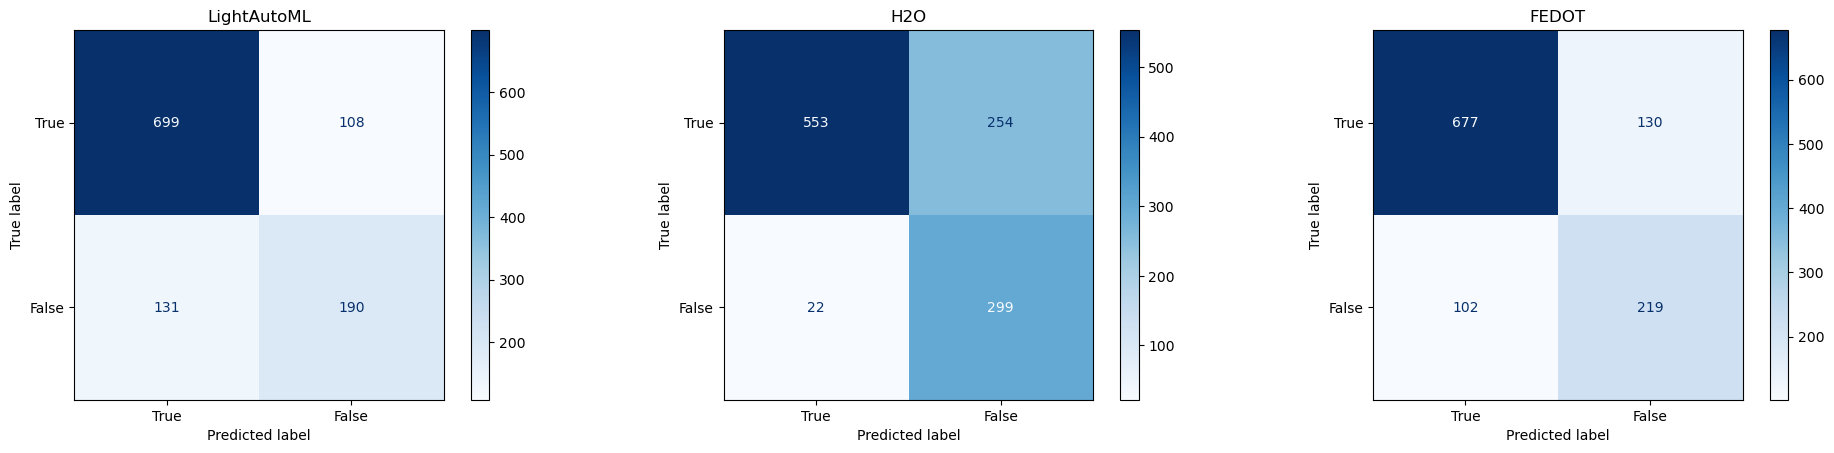

In [61]:
target_names = ['True', 'False']

plt.subplots_adjust(right=3)

ax1 = plt.subplot(1, 3, 1)
ax1.set_title('LightAutoML')

ax2 = plt.subplot(1, 3, 2)
ax2.set_title('H2O')

ax3 = plt.subplot(1, 3, 3)
ax3.set_title('FEDOT')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_lama_validation, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g', ax=ax1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_h2o_validation, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g', ax=ax2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_fedot_validation, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g', ax=ax3)

plt.show()

### Задание 3-4

Усовершенствуйте решения за счет предобработки исходных данных. Проверьте свои модели на тестовой и валидационной выборке.

In [79]:
from imblearn.over_sampling import SMOTE

In [81]:
# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = table_data[(table_data[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

In [83]:
target_column = 'Healthy_Status'

smote = SMOTE(random_state=0)
X_initial = full_df_filtered.drop(target_column, axis=1)
y_initial = full_df_filtered[target_column]

X, y = smote.fit_resample(X_initial, y_initial)

df = pd.DataFrame(X, columns=X_initial.columns)
df[target_column] = y

df[target_column].value_counts()

Healthy_Status
0    5039
1    5039
Name: count, dtype: int64

In [85]:
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['Healthy_Status'], random_state=42)

## AutoML LAMA

In [88]:
automl2 = TabularAutoML(
    task=Task('binary'),
    timeout=100,
    cpu_limit=4,
    reader_params={'n_jobs': 4, 'cv': 3, 'random_state': 42},
)

In [90]:
predictions2 = automl2.fit_predict(train_data, roles={'target': 'Healthy_Status'}, verbose=0).data

In [91]:
test_predictions = automl2.predict(test_data).data

In [92]:
for i in range(len(test_predictions)):
    if test_predictions[i] > 0.5:
        test_predictions[i] = 1
    else:
        test_predictions[i] = 0

In [93]:
f1_lama_test = f1_score(test_data['Healthy_Status'], test_predictions)

In [94]:
cm_lama_test = confusion_matrix(test_data['Healthy_Status'], test_predictions, labels=[0, 1])

In [95]:
validation_predictions2 = automl2.predict(validation_data).data

In [96]:
for i in range(len(validation_predictions2)):
    if validation_predictions2[i] > 0.5:
        validation_predictions2[i] = 1
    else:
        validation_predictions2[i] = 0

In [97]:
f1_lama_validation2 = f1_score(validation_data['Healthy_Status'], validation_predictions2)

In [98]:
cm_lama_validation2 = confusion_matrix(validation_data['Healthy_Status'], validation_predictions2, labels=[0, 1])

## AutoML H2O

In [100]:
# Инициализация H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 21.0.5+-13047016-b750.29, mixed mode)
  Starting server from C:\Users\dvm10\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\dvm10\AppData\Local\Temp\tmppy6k1215
  JVM stdout: C:\Users\dvm10\AppData\Local\Temp\tmppy6k1215\h2o_dvm10_started_from_python.out
  JVM stderr: C:\Users\dvm10\AppData\Local\Temp\tmppy6k1215\h2o_dvm10_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,5 months and 16 days
H2O_cluster_name:,H2O_from_python_dvm10_nqdt0c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.932 Gb
H2O_cluster_total_cores:,20
H2O_cluster_allowed_cores:,20
H2O_cluster_status:,"locked, healthy"


In [101]:
# Преобразование данных в H2OFrame
def to_h2o_frame(data, target_col='Healthy_Status'):
    hf = h2o.H2OFrame(data)
    hf[target_col] = hf[target_col].asfactor()  # Для классификации
    return hf


In [102]:
train_hf = to_h2o_frame(train_data)
validation_hf = to_h2o_frame(validation_data)
test_hf = to_h2o_frame(test_data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [103]:
# Определение признаков и целевой переменной
x = train_hf.columns
x.remove('Healthy_Status')
y = 'Healthy_Status'

In [104]:
# Создание и обучение модели H2OAutoML (эквивалент 5 минут TPOT)
aml2 = H2OAutoML(
    max_runtime_secs=300,  # 5 минут = 300 секунд
    seed=42,
    verbosity='info',
    exclude_algos=["DeepLearning"]  # Для более быстрого обучения
)
aml2.train(x=x, y=y, training_frame=train_hf)

AutoML progress: |
23:44:03.191: Project: AutoML_1_20250418_234403
23:44:03.192: 5-fold cross-validation will be used.
23:44:03.194: Setting stopping tolerance adaptively based on the training frame: 0.011137266274738303
23:44:03.194: Build control seed: 42
23:44:03.194: training frame: Frame key: AutoML_1_20250418_234403_training_py_9_sid_81f2    cols: 9    rows: 8062  chunks: 1    size: 123104  checksum: -43834849179670
23:44:03.194: validation frame: NULL
23:44:03.194: leaderboard frame: NULL
23:44:03.194: blending frame: NULL
23:44:03.194: response column: Healthy_Status
23:44:03.194: fold column: null
23:44:03.194: weights column: null
23:44:03.200: AutoML: XGBoost is not available; skipping it.
23:44:03.201: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), d

key,value
Stacking strategy,cross_validation
Number of base models (used / total),189/197
# GBM base models (used / total),186/194
# DRF base models (used / total),2/2
# GLM base models (used / total),1/1
Metalearner algorithm,GBM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
Custom metalearner hyperparameters,None


In [105]:
# Получение лучшей модели
best_model2 = aml2.leader

In [106]:
# Предсказания на тестовом наборе
test_preds = best_model2.predict(test_hf)
y_test_h2o_predict = test_preds['predict'].as_data_frame().values.ravel()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [107]:
# Метрики для тестового набора
f1_h2o_test = f1_score(
    test_data['Healthy_Status'].values, 
    y_test_h2o_predict
)
cm_h2o_test = confusion_matrix(
    test_data['Healthy_Status'].values,
    y_test_h2o_predict, 
    labels=[0, 1]
)

In [108]:
# Предсказания на валидационном наборе
val_preds = best_model2.predict(validation_hf)
y_validation_h2o_predict2 = val_preds['predict'].as_data_frame().values.ravel()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [109]:
# Метрики для валидационного набора
f1_h2o_validation2 = f1_score(
    validation_data['Healthy_Status'].values, 
    y_validation_h2o_predict2
)
cm_h2o_validation2 = confusion_matrix(
    validation_data['Healthy_Status'].values,
    y_validation_h2o_predict2, 
    labels=[0, 1]
)

In [110]:
# Завершение работы H2O
h2o.cluster().shutdown()

H2O session _sid_81f2 closed.


## AutoML FEDOT

In [112]:
fedot_model2 = Fedot(problem='classification', timeout=3)

In [113]:
fedot_model2.fit(features=X_train, target=y_train)

2025-04-18 23:48:24,487 - ApiComposer - Initial pipeline was fitted in 1.8 sec.
2025-04-18 23:48:24,489 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 9.2 sec.
2025-04-18 23:48:24,490 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2025-04-18 23:48:24,505 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 3 min. Set of candidate models: ['bernb', 'catboost', 'dt', 'fast_ica', 'isolation_forest_class', 'knn', 'lgbm', 'logit', 'mlp', 'normalization', 'pca', 'poly_features', 'qda', 'resample', 'rf', 'scaling', 'xgboost'].
2025-04-18 23:48:24,644 - ApiComposer - Pipeline composition started.


Generations:   0%|                                                                          | 0/10000 [00:00<?, ?gen/s]

2025-04-18 23:48:36,668 - MultiprocessingDispatcher - 6 individuals out of 6 in previous population were evaluated successfully.
2025-04-18 23:49:02,650 - MultiprocessingDispatcher - 20 individuals out of 21 in previous population were evaluated successfully.
2025-04-18 23:49:24,088 - MultiprocessingDispatcher - 11 individuals out of 11 in previous population were evaluated successfully.
2025-04-18 23:49:27,874 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|                                                              | 1/10000 [01:03<175:24:42, 63.15s/gen]

2025-04-18 23:49:32,937 - MultiprocessingDispatcher - 11 individuals out of 11 in previous population were evaluated successfully.
2025-04-18 23:49:40,423 - MultiprocessingDispatcher - 9 individuals out of 9 in previous population were evaluated successfully.
2025-04-18 23:49:41,243 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|                                                               | 2/10000 [01:16<94:03:39, 33.87s/gen]

2025-04-18 23:49:46,513 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2025-04-18 23:49:48,198 - MultiprocessingDispatcher - 12 individuals out of 13 in previous population were evaluated successfully.


Generations:   0%|                                                               | 3/10000 [01:23<59:55:37, 21.58s/gen]

2025-04-18 23:50:01,967 - MultiprocessingDispatcher - 30 individuals out of 31 in previous population were evaluated successfully.
2025-04-18 23:50:05,518 - MultiprocessingDispatcher - 26 individuals out of 26 in previous population were evaluated successfully.
2025-04-18 23:50:05,534 - MultiprocessingDispatcher - 18 individuals out of 18 in previous population were evaluated successfully.


Generations:   0%|                                                               | 4/10000 [01:40<55:15:51, 19.90s/gen]

2025-04-18 23:50:05,582 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                               | 4/10000 [01:40<70:00:47, 25.21s/gen]

2025-04-18 23:50:05,666 - ApiComposer - Hyperparameters tuning started with 1 min. timeout


2025-04-18 23:50:09,715 - SimultaneousTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [catboost]}
catboost - {'n_jobs': 1, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': False, 'allow_writing_files': False, 'use_eval_set': True, 'use_best_model': True, 'enable_categorical': True} 
Initial metric: [0.859]
  0%|                                                       | 125/100000 [01:13<16:15:08,  1.71trial/s, best loss: inf]
2025-04-18 23:51:23,489 - SimultaneousTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [catboost]}
catboost - {'n_jobs': 1, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'Symmetr

{'depth': 1, 'length': 1, 'nodes': [catboost]}

In [114]:
y_test_fedot__predict = fedot_model2.predict(X_test)

In [115]:
f1_fedot_test = f1_score(y_test, y_test_fedot__predict)

In [116]:
cm_fedot_test = confusion_matrix(y_test, y_test_fedot__predict, labels=[0, 1])

In [117]:
y_validation_fedot__predict2 = fedot_model2.predict(X_validation)

In [118]:
f1_fedot_validation2 = f1_score(y_validation, y_validation_fedot__predict2)

In [119]:
cm_fedot_validation2 = confusion_matrix(y_validation, y_validation_fedot__predict2, labels=[0, 1])

In [120]:
df_metrics_test = pd.DataFrame(
    {
        'automl': ['LightAutoML', 'H2O', 'FEDOT'],
        'F1 метрика для валидационных данных': [f1_lama_validation2, f1_h2o_validation2, f1_fedot_validation2],
    }
)
df_metrics_test = df_metrics_test.set_index('automl')
df_metrics_test

,F1 метрика для валидационных данных
automl,
LightAutoML,0.737143
H2O,0.971963
FEDOT,0.653731


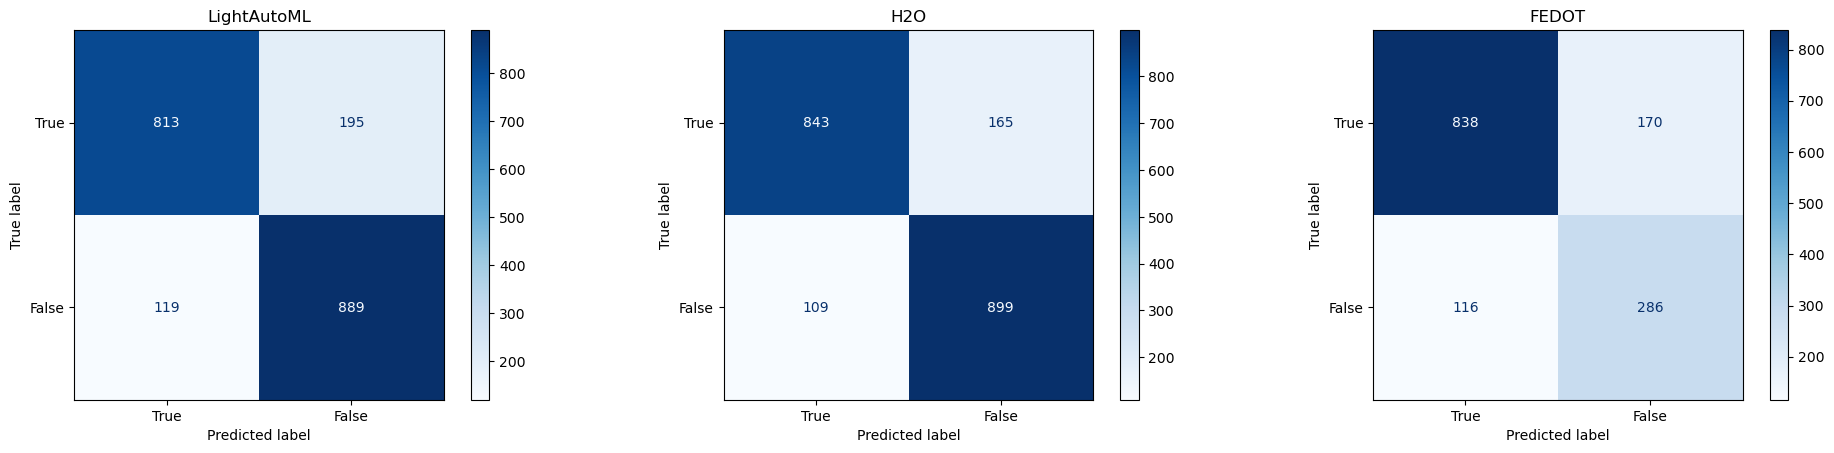

In [121]:
target_names = ['True', 'False']

plt.subplots_adjust(right=3)

ax1 = plt.subplot(1, 3, 1)
ax1.set_title('LightAutoML')

ax2 = plt.subplot(1, 3, 2)
ax2.set_title('H2O')

ax3 = plt.subplot(1, 3, 3)
ax3.set_title('FEDOT')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_lama_test, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g', ax=ax1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_h2o_test, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g', ax=ax2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_fedot_test, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g', ax=ax3)

plt.show()

In [122]:
df_metrics_validation = pd.DataFrame(
    {
        'type': ['До обработки', 'После обработки'],
        'LightAutoML': [f1_lama_validation, f1_lama_validation2],
        'H2O': [f1_h2o_validation, f1_h2o_validation2],
        'FEDOT': [f1_fedot_validation, f1_fedot_validation2]
    }
)
df_metrics_validation = df_metrics_validation.set_index('type')
df_metrics_validation

,LightAutoML,H2O,FEDOT
type,,,
До обработки,0.613893,0.684211,0.653731
После обработки,0.737143,0.971963,0.653731
